In [1]:
import numpy as np
import quantities

from matplotlib import pyplot as plt
from dlens_vx_v3 import hxcomm
from tabulate import tabulate

from pynn_brainscales import brainscales2 as pynn
from pynn_brainscales.brainscales2.standardmodels.cells import SpikeSourceArray
from pynn_brainscales.brainscales2.standardmodels.synapses import StaticSynapse

from _static.common.helpers import setup_hardware_client
from _static.common.helpers import get_nightly_calibration

In [2]:
## Configuration
wait_before_experiment = 0.003 * quantities.ms
isi = 1 * quantities.us

In [3]:
### General Setup

# Setup BrainScaleS-2
setup_hardware_client()

# setup PyNN and set calibration cache path
from pathlib import Path
pynn.setup(calibration_cache=[Path(".calix")])

INFO  12:11:34,341  demo_helpers Using setup hxcube7fpga0chip57_1


In [4]:
### Network Structure


## Create and initialize neuronal population with 3 neurons:
# - dendritic compartment
# - somatic compartment
# - reference/point neuron
pop_out = pynn.Population(3, pynn.cells.CalibHXNeuronCuba(v_thresh=100, v_reset=[70, 100, 70], tau_refrac=[10, 50, 10]))

ref_neuron = pynn.PopulationView(pop_out, slice(0, 1))
dendrite = pynn.PopulationView(pop_out, slice(1, 2))
soma = pynn.PopulationView(pop_out, slice(2, 3))

# Define input spikes, population and connections for dendritic coincidence spikes
spikes_coincidence = wait_before_experiment + np.arange(5) * isi
spikes_coincidence = np.array(spikes_coincidence.rescale(quantities.ms))
pop_in_dendritic = pynn.Population(2, # ToDo: Why 2 neurons?
                               SpikeSourceArray(spike_times=spikes_coincidence))
exc_proj = pynn.Projection(pop_in_dendritic, dendrite,
                           pynn.AllToAllConnector(),
                           synapse_type=StaticSynapse(weight=63),
                           receptor_type="excitatory")

# Define input spikes, population and connections for somatic spikes
pop_in_soma = pynn.Population(4,    # ToDo: Why 4 neurons?
                SpikeSourceArray(spike_times=[0.025]))
pynn.Projection(pop_in_soma, soma,
                pynn.AllToAllConnector(),
                synapse_type=StaticSynapse(weight=40),
                receptor_type="excitatory")
pynn.Projection(pop_in_soma, ref_neuron,
                pynn.AllToAllConnector(),
                synapse_type=StaticSynapse(weight=40),
                receptor_type="excitatory")

pynn.preprocess()

dendrite.actual_hwparams[0].multicompartment.enable_conductance = True
dendrite.actual_hwparams[0].multicompartment.i_bias_nmda = 30
dendrite.actual_hwparams[0].multicompartment.connect_soma_right = True
dendrite.actual_hwparams[0].refractory_period.reset_holdoff = 0

soma.actual_hwparams[0].multicompartment.connect_soma = True

Neuron          Spike 0
------------  ---------
point neuron    0.02734
dendrite        0.0053
soma            0.02691



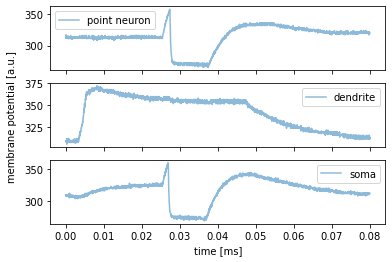

In [5]:
### Emulation and Plotting

%matplotlib inline

# Define neurons to be recorded
recorded_neurons = [0, 1, 2]
labels = ["point neuron", "dendrite", "soma"]
fig, axs = plt.subplots(len(recorded_neurons), 1, sharex="all")
spike_times = []
num_spikes = 0

## Run network and plot results
for idx, neuron_id in enumerate(recorded_neurons):
    # Define neuron to be recorded in this run
    p_view = pynn.PopulationView(pop_out, [neuron_id])
    p_view.record(["v", "spikes"])
    
    # Run simulation for 0.08 seconds
    pynn.run(0.08)
    
    # Retrieve voltage and spikes from recorded neuron
    mem_v = p_view.get_data("v").segments[-1].irregularlysampledsignals[0]
    spikes = p_view.get_data("spikes").segments[-1].spiketrains
    
    # Print spikes 
    spike_times.append([labels[idx],] + np.array(spikes.multiplexed[1]).round(5).tolist())
    num_spikes = max(num_spikes, len(spikes.multiplexed[1]))
    
    # Plot 
    axs[idx].plot(mem_v.times, mem_v, alpha=0.5, label=labels[idx])
    axs[idx].legend()
    #axs[idx].set_ylim(100, 800)
    pynn.reset()
    pop_out.record(None)

# Print spike times
header_spikes = [f'Spike {i}' for i in range(num_spikes)]
print(tabulate(spike_times, headers=['Neuron'] + header_spikes) + '\n')

# Update figure, save and show it
axs[-1].set_xlabel("time [ms]")
fig.text(0.025, 0.5, "membrane potential [a.u.]", va="center", rotation="vertical")
plt.savefig("excitatory_neuron.pdf")